# Introduction

## What is introgression

Introgression is the phenomenon that genetic materials move from one lineage into another lineage between two different species.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/Homo_sapiens_lineage.svg/1200px-Homo_sapiens_lineage.svg.png" alt="human_introgression" width="500"/>

**Figure 1 Interbreeding between archaic and modern humans.** This figure is from https://en.wikipedia.org/wiki/Interbreeding_between_archaic_and_modern_humans.

## Strategies for identifying introgressed regions

There are two major strategies to indentify introgressed regions.
1. If we have genomes from source populations, for example, genomes from Neanderthals, we can compare modern human genomes with Neanderthal genomes directly.
2. If we do not have source genomes, for example, we want to indentify introgression from an unknown lineage (ghost introgression), we can apply some statistical models to find out unusal regions.

When you have several sources, you may observe differential matching to these sources. This can give you a clou who was the source population!

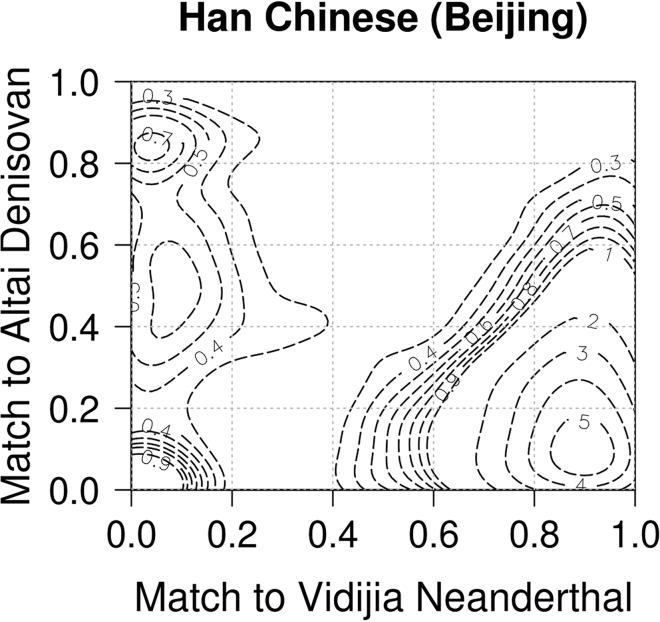

Several tools can identify introgression without source populations (and you may try to match it later).
- [SkovHMM](https://github.com/LauritsSkov/Introgression-detection)
- [sstar](https://github.com/admixVIE/sstar)
- [SPrime](https://github.com/browning-lab/sprime)

For SPrime, there is a nice tutorial, including how to create plots, here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8164089/

Here, we will try **sstar**, one of the available tools for this purpose.


## What is S*?

The S* statistic has been used first to describe deep human population structure, then to suggest Neanderthal introgression **before** the Neanderthal genome was sequenced, then to infer the introgression landscape of Neanderthal and Denisovan introgression in modern humans.

It measures, to put it simply, the amount of private variation (compared to an outgroup population) in close proximity:

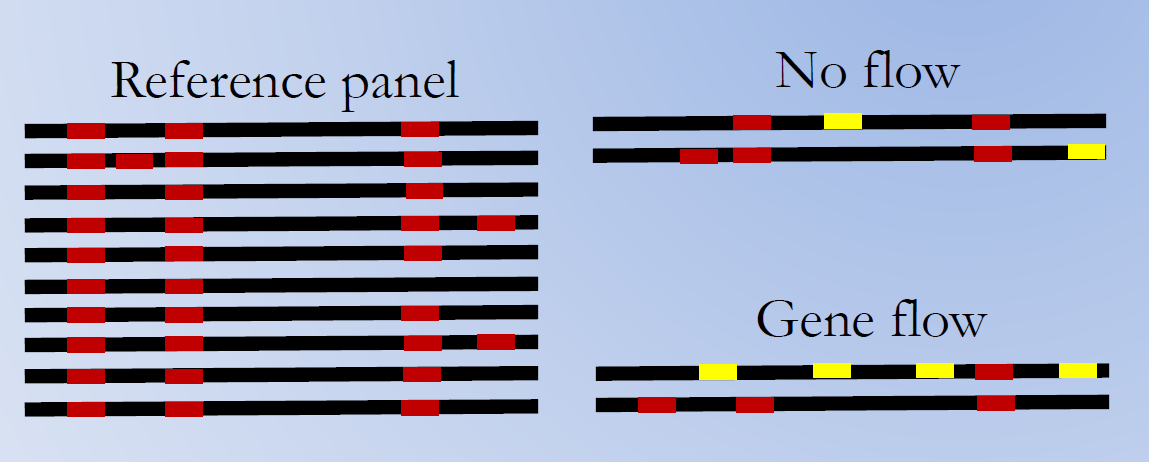

**sstar** is a tool to use this statistic on a set of genomes (here is the paper: https://doi.org/10.1093/molbev/msac212). It is a python package to use S* for getting introgressed pieces of the genome. You can go and read (and modify) the source code in python using editors or command line tools.

To apply sstar, several steps are performed.

* First, the S* statistic is calculated in small windows along the genome.

* Second, based on a demographic model, the expected S* scores for this population ar estimated.

* Third, significance is assessed, i.e. a threshold based on the simulations is applied to the windows.

* Fourth, the introgressed fragments are defined.

* An optional fifth step, in case you have one or two possible source genomes, is to calculate the match to these sources.


## Install sstar

There is extensive documentation here: https://sstar.readthedocs.io/en/latest/

The very first thing: install it through the command line!

```
export LD_LIBRARY_PATH=/opt/R/4.1.3/lib/R/lib:$LD_LIBRARY_PATH

pip install sstar
```

And get the data:
```
cd ~/notebooks/introgression/data/

wget https://ucloud.univie.ac.at/index.php/s/sjVDEgg2KDvI9u8/download

tar -zxvf download
```

This is the same vcf file used in the first Challenge session. But this is not quite in the shape to use it for the program - what we need is a vcf file of only the segregating sites in only the source and target populations. That means, we need to filter the dataset, remove archaic individuals, missing data and non-variable sites.

You already know how to do that, right? Write this into a file named `testset.filtered.nomis.vcf.gz`.

How many sites did we start with and end with?


## Calculating S* scores

The scores can be calculated with the function `sstar score`, and defined lists of individuals that are the "Reference panel" (no introgression) and the "Target panel" (potentially introgression). Check the two lists, then apply the function.

```
sstar score --vcf testset.filtered.nomis.vcf.gz --ref ref.ind.list --tgt tgt.ind.list --output testset.score.results
```

This is the most basic command, but there are parameters one could change. Ask for help!

Now we inspect the testset.score.results table, what is there?


## Using a demographic model to know what is significant

This uses the program `ms` to simulate data. We know that the prophecy claims "[Thou shalt use msprime!](https://twitter.com/vsbuffalo/status/1358969320244531205)", but S* was developed with `ms` for some of its features. At some point in the future, this is likely to change, and I hope you won't need `ms`. But for now we can and need to use it within the sstar package as is.

The good thing is that things are already designed in a nice way: we can put in demographic models in a human-readable format. I just downloaded the human model from here: https://popsim-consortium.github.io/demes-spec-docs/main/gallery.html to go ahead with this part.

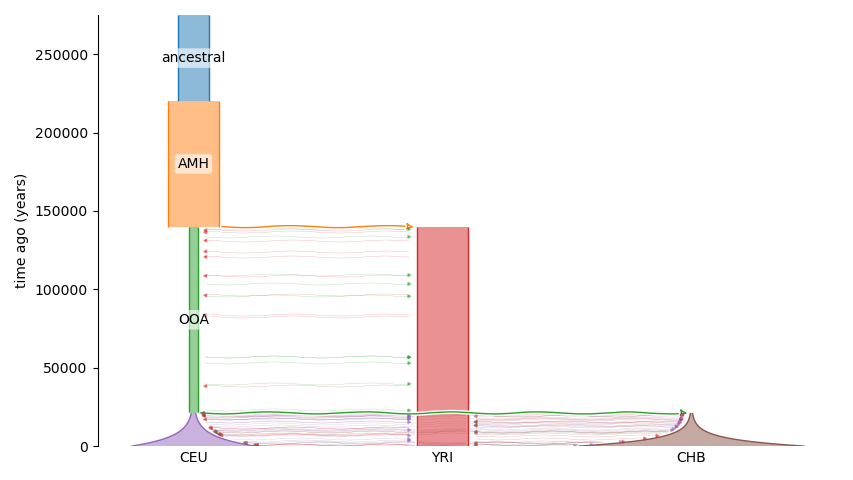

```
description: The Gutenkunst et al. (2009) OOA model.
doi:
- https://doi.org/10.1371/journal.pgen.1000695
time_units: years
generation_time: 25

demes:
- name: ancestral
  description: Equilibrium/root population
  epochs:
  - {end_time: 220e3, start_size: 7300}
- name: AMH
  description: Anatomically modern humans
  ancestors: [ancestral]
  epochs:
  - {end_time: 140e3, start_size: 12300}
- name: OOA
  description: Bottleneck out-of-Africa population
  ancestors: [AMH]
  epochs:
  - {end_time: 21.2e3, start_size: 2100}
- name: YRI
  description: Yoruba in Ibadan, Nigeria
  ancestors: [AMH]
  epochs:
  - start_size: 12300
- name: CEU
  description: Utah Residents (CEPH) with Northern and Western European Ancestry
  ancestors: [OOA]
  epochs:
  - {start_size: 1000, end_size: 29725}
- name: CHB
  description: Han Chinese in Beijing, China
  ancestors: [OOA]
  epochs:
  - {start_size: 510, end_size: 54090}

migrations:
- {demes: [YRI, OOA], rate: 25e-5}
- {demes: [YRI, CEU], rate: 3e-5}
- {demes: [YRI, CHB], rate: 1.9e-5}
- {demes: [CEU, CHB], rate: 9.6e-5}
```


The command you *would* then run is the following:

```
# First: compile the ms program
tar -zxvf ms.tar.gz
cd msdir
gcc -o ms ms.c streec.c rand1.c -lm
cd..

# Second: run sstar to get the data
sstar quantile --model human_model.yaml --ms-dir /scratch/admixlab/mktest/sstar/ext/msdir/ --N0 1000 --nsamp 40 --nreps 20000 --ref-index 4 --ref-size 20 --tgt-index 5 --tgt-size 20 --mut-rate 1e-8 --rec-rate 1e-8 --seq-len 50000 --snp-num-range 10 450 5 --output-dir quantiles --thread 16
```

Since this part takes quite some time (and memory), I prepared the output already (takes a few hours or up to days depending on thread number). But you can use the commands above to run the actual thing (e.g. if you had a different population setting you want to look at)!

Let's inspect the file `quantile.summary.txt`


## Applying the threshold

Now, we have empirically measured S* in our individuals, and an idea what to expect given the history of humans. It's also good to have a recombination map to be able to differentiate between haplotypes.

In this example, we use the calculated scores with the precalculated simulated expectations, and a recombination map.

```
sstar threshold --score testset.score.results --sim-data quantile.summary.txt --quantile 0.99 --output testset.threshold.results

```

We may inspect the output file.


## Get the introgressed tracts

So, now let's see how much of these fragments are significantly different from an expectation without gene flow.

```
sstar tract --threshold testset.threshold.results --output-prefix testset.tracts
```

Let's look at the output. This is in bed file format. What is this?

## Bed files

This filetype was invented to store genomic features (https://genome.ucsc.edu/FAQ/FAQformat.html).

It is commonly used, and a common source of confusion because it is "0-based", i.e. the chromosome starts from "0", not from "1".

Don't ask me!

Anyhow, you can work with these in bedtools (https://bedtools.readthedocs.io/en/latest/). There are also [some](https://github.com/vinay-swamy/RBedtools) [R](https://kasperdanielhansen.github.io/genbioconductor/html/GenomicRanges_GRanges.html) [packages](https://cran.r-project.org/web/packages/bedr/vignettes/Using-bedr.html) with the same, overlapping or expanding functionalities.

## Calculating the match to a source population

Then, we can calculate the match to the Neanderthal genome (i.e. how many of the SNPs do agree with the Neanderthal), and get significant windows annotated with the matchrate.

First, we have to bring back the archaic individuals to the variable positions in the sample (this is annotation).

```
bcftools view -H testset.filtered.nomis.vcf.gz | cut -f1-2 > varpos.txt
bcftools index testset.filtered.vcf.gz
bcftools view -R varpos.txt -S arch.list testset.filtered.vcf.gz | bcftools merge -m none --no-index testset.filtered.nomis.vcf.gz - | bgzip > testset.filtered.nomis.witharch.vcf.gz
```

Now, we can calculate the match and obtain the introgressed tracts for Neandertal introgression.

```
sstar matchrate --vcf testset.filtered.nomis.witharch.vcf.gz --ref ref.ind.list --tgt tgt.ind.list --src altai.list --score testset.threshold.results --mapped-region testset.tracts.bed --output altai.match.rate.results
sstar tract --threshold testset.threshold.results --output-prefix altai.final --match-rate altai.match.rate.results
```

Now we have a look at the new bed file created by this step. What do we see?

Have a look at merged stuff in a single individual:

```
grep "HG02223" altai.final.bed | bedtools sort | bedtools merge > one_ind.bed
```


## Let's plot some of this in R!

What is the distribution of matchrates?

First, as a simple histogram for all samples:

```
R --vanilla

setwd("~/appladmix/notebooks/4_introgression/data")
matchtab<-read.table("altai.final.bed",sep="\t",header=F)
hist(matchtab[,5])

```

What do we see here?

Then, as a nice violinplot per sample, something like we see in papers:

```
library(ggplot2)

mtab<-data.frame(match_rate=matchtab[,5],sample=matchtab[,4])

ggplot(mtab,aes(factor(sample), match_rate)) + 
    geom_violin(scale="width",aes(fill=factor(sample)),adjust=1.0,draw_quantiles = c(0.5)  ) +
    geom_jitter(height = 0, width = 0.25,size=0.15) + geom_segment(aes(x=0.0,y=0,xend=0.0,yend=1))    + 
    theme_bw() +
    theme(panel.border = element_blank(),panel.grid.major = element_blank(),panel.grid.minor = element_blank(),plot.background = element_rect(fill = "white"),legend.position="none",axis.text.y= element_text(size=8),axis.title.y= element_text(size=10), axis.ticks.x = element_blank(), plot.title = element_text(face="bold",hjust=0.5,size=12)) +
    xlab("")+ylab("Matchrate (proportion of SNPs)") + ggtitle(label="Distribution of matchrates")
    
    #

```
What do we see?

Now another plot: What is the frequency of introgressed regions?

```
myfreq<-as.data.frame(table(as.data.frame(table(matchtab[,2]))[,2]))
nicecol <- colorRampPalette(c("orange", "red"))(10)

barplot(myfreq[,2],beside=T,names.arg=myfreq[,1],col=c(nicecol))
```

What does that mean?

In which situation would it look different?

```
ind<-read.table("one_ind.bed",sep="\t",header=F)

lengs<-ind[,3]-ind[,2]

range(lengs)
sum(lengs)
sum(lengs)/35000000
```
